# 3 Tile tract and patch lists

In this notebook we will generate the list of patches that are present on a given VISTA tile. We will do so such that the tile is completely covered. That is we aim to provide every patch that contains any region of the tile.

In [1]:
from astropy.table import Table, Column, vstack # Perhaps we should use LSST tables

import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
VIDEO_IN = './data/video_images_overview_20200820.csv'
VHS_IN = './data/vhs_images_overview_20201102.csv'
VIKING_IN = './data/viking_images_overview_20201218.csv'
HSC_IN = './data/hsc_images_overview_20210315.csv'

In [3]:
video_ims = Table.read(VIDEO_IN)
vhs_ims = Table.read(VHS_IN)
viking_ims = Table.read(VIKING_IN)
hsc_ims = Table.read(HSC_IN)

In [4]:
len(vhs_ims),len(video_ims),len(viking_ims),len(hsc_ims)

(887732, 137269, 229841, 189936)

In [5]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
       
    return filetype
video_ims['type'] = [fileToType(f) for f in video_ims['file']]
vhs_ims['type'] = [fileToType(f) for f in vhs_ims['file']]
viking_ims['type'] = [fileToType(f) for f in viking_ims['file']]

In [6]:
video_ims = video_ims[video_ims['type']=='tile']
vhs_ims = vhs_ims[vhs_ims['type']=='tile']
viking_ims = viking_ims[viking_ims['type']=='tile']

In [7]:
len(vhs_ims),len(video_ims),len(viking_ims)

(33971, 2205, 6852)

In [8]:
#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

#Following taken from dmu1/2_Survey_comparisons.ipynb test choice
coord = SpherePoint(35.429025*degrees,-4.90853*degrees)
config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sm.findTract(coord)

TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431])

In [9]:
## Test on known tile

In [10]:
#Tile from dmu4/dmu4_Example
EX_TILE = "20121122/v20121122_00088_st_tl.fit"
ex_row = video_ims[
    video_ims['file'] == "/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/"+EX_TILE
][0]
ex_row

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,type
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20121122/v20121122_00088_st_tl.fit,35.43265,-4.72313,36.1259211592099,36.13048720302681,34.91284867786413,34.914758535953574,-4.074792762244068,-5.561089113115699,-4.077214438128979,-5.563516534082509,Ks,216357120,95f818d1b99dcee749b276666480cdc6,tile


In [11]:
ex_row['ra_0_0']

36.1259211592099

In [12]:
patches = sm.findTractPatchList(
        [
            SpherePoint(ex_row['ra_0_0']*degrees,ex_row['dec_0_0']*degrees),
            SpherePoint(ex_row['ra_0_y']*degrees,ex_row['dec_0_y']*degrees),
            SpherePoint(ex_row['ra_x_0']*degrees,ex_row['dec_x_0']*degrees),
            SpherePoint(ex_row['ra_x_y']*degrees,ex_row['dec_x_y']*degrees)
        ]
    )
t = patches[0][0]

In [13]:

tp_dict ={}
for tract in patches:
    #print(tract[0].getId())
    #tp_dict[tract[0].getId()] = [[t.getIndex()[0],t.getIndex()[1]] for t in tract[1]]
    tp_dict[int(tract[0].getId())] = [t.getIndex() for t in tract[1]]

j = json.dumps(tp_dict, separators=(',', ':')) 
j

'{"8766":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],"8524":[[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,2],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]],"8765":[[0,0],[0,1],[0,2]],"8523":[[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]}'

In [14]:
def corners_to_patch_list(ex_row):
    """Take a ra dec limited region and return a list of all patches contained witing it
    
    Inputs
    =======
    ex_row    astropy.table.row
              Row of image overview table containing corner columns
    
    Returns
    =======
    j        str
             String which can be loaded by json to create a dictionary
             the tracts indices are strings as required by json
    """
    try:
        patches = sm.findTractPatchList(
            [
                SpherePoint(ex_row['ra_0_0']*degrees,ex_row['dec_0_0']*degrees),
                SpherePoint(ex_row['ra_0_y']*degrees,ex_row['dec_0_y']*degrees),
                SpherePoint(ex_row['ra_x_0']*degrees,ex_row['dec_x_0']*degrees),
                SpherePoint(ex_row['ra_x_y']*degrees,ex_row['dec_x_y']*degrees)
            ]
        )
    
        tp_dict ={}
        for tract in patches:
            tp_dict[int(tract[0].getId())] = [t.getIndex() for t in tract[1]]
        j = json.dumps(tp_dict, separators=(',', ':')) 
    except:
        #print(ex_row['file']+" failed")
        j=''
    return j
corners_to_patch_list(video_ims[0])

'{"8766":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],"8524":[[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,2],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]],"8765":[[0,0],[0,1],[0,2]],"8523":[[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]}'

In [15]:
video_ims[0]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,type
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20140924/v20140924_00444_st_tl.fit,35.429542,-4.72215,36.12993723683939,36.13433423332165,34.912894878395214,34.91462725348546,-4.072782101046067,-5.559458172880838,-4.07547203760631,-5.562153562881393,Y,148561920,ccef567359a9d3f1cef197b5b5dad958,tile


mkdir: figs: File exists


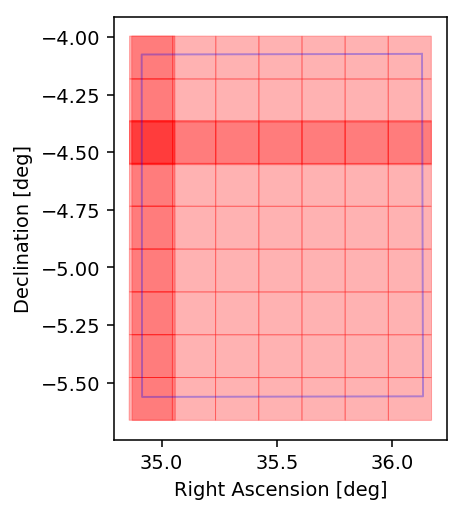

In [16]:
!mkdir figs
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
        
test = json.loads(corners_to_patch_list(video_ims[0]))
for tract in test:
    t = sm.generateTract(int(tract))
    for patch in test[tract]:
        
        p = patch
        
    
    
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'r', alpha=0.3, linewidth=0.5)

t =video_ims[0]        
ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]  
ax.plot(ra, dec, c = 'b', alpha=0.3, linewidth=1.0)
    
ax.axis('scaled')
#ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/test_im.pdf', overwrite=True)
fig.savefig('./figs/test_im.png', overwrite=True)

In [17]:
video_ims['tract_patch_json'] = [corners_to_patch_list(row) for row in video_ims]
vhs_ims['tract_patch_json'] = [corners_to_patch_list(row) for row in vhs_ims]
viking_ims['tract_patch_json'] = [corners_to_patch_list(row) for row in viking_ims]
#corners_to_patch_list(video_ims[0])

In [18]:
video_ims[0]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,type,tract_patch_json
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str5,str631
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20140924/v20140924_00444_st_tl.fit,35.429542,-4.72215,36.12993723683939,36.13433423332165,34.912894878395214,34.91462725348546,-4.072782101046067,-5.559458172880838,-4.07547203760631,-5.562153562881393,Y,148561920,ccef567359a9d3f1cef197b5b5dad958,tile,"{""8766"":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],""8524"":[[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,2],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]],""8765"":[[0,0],[0,1],[0,2]],""8523"":[[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]}"


In [19]:
video_ims[6]['tract_patch_json']

'{"3053":[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]],"3054":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],"2876":[[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8]],"2877":[[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]]}'

In [20]:
#video_ims.write(VIDEO_IN.replace('images','tiles_tracts_patches'),overwrite=True)
vhs_ims.write(VHS_IN.replace('images','tiles_tracts_patches'),overwrite=True)

In [21]:
viking_ims.write(VIKING_IN.replace('images','tiles_tracts_patches'),overwrite=True)

In [22]:
video_ims = Table.read(VIDEO_IN.replace('images','tiles_tracts_patches'))

In [23]:
video_ims.add_column(Column(
    data= [t.split('/')[-2] for t in video_ims['file']],
    name='date'))

In [24]:
tract = 8524
patch = [3,5]

#has_tract_patch = (
#    [str(tract) in j for j in video_ims['tract_patch_json']]
#    and [patch in j for j in video_ims['tract_patch_json']]
#)

In [25]:
def has_patch(tract, patch, j):
    """Take a json string and return true if a given patch is in it
    """
    j = json.loads(j)
   
    try:
        has_patch = patch in j[str(tract)]
    except KeyError:
        has_patch = False
    return has_patch

In [26]:
import json
j = json.loads(video_ims[6]['tract_patch_json'])

In [27]:
mask = [has_patch(tract, patch, j) for j in video_ims['tract_patch_json']]
mask &= video_ims['filter'] =='Y'
np.sum(mask)

218

In [28]:
len(np.unique(video_ims[mask]['date']))

119

In [29]:
s = "makeCoaddTempExp.py data --rerun coadd"
for date in np.unique(video_ims[mask]['date'])[:5]:
    d = date[0:4]+'-'+date[4:6]+'-'+date[6:9]#+'^'
    s+=" --selectId filter=VISTA-Y dateObs={} ".format(d)
s + "--id filter=VISTA-Y tract=8524 patch=3,5 --clobber-config"

'makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Y dateObs=2009-11-07  --selectId filter=VISTA-Y dateObs=2009-11-08  --selectId filter=VISTA-Y dateObs=2009-11-10  --selectId filter=VISTA-Y dateObs=2009-11-11  --selectId filter=VISTA-Y dateObs=2009-11-12 --id filter=VISTA-Y tract=8524 patch=3,5 --clobber-config'

In [30]:
has_patch(8766, [2,0], video_ims['tract_patch_json'][0])

True

In [31]:
video_ims.colnames

['file',
 'ra',
 'dec',
 'ra_0_0',
 'ra_0_y',
 'ra_x_0',
 'ra_x_y',
 'dec_0_0',
 'dec_0_y',
 'dec_x_0',
 'dec_x_y',
 'filter',
 'size',
 'hash',
 'type',
 'tract_patch_json',
 'date']

In [32]:
patch

[3, 5]

In [33]:
has_8524_33 = np.array([has_patch(8524, [3,3], j) for j in video_ims['tract_patch_json']])
has_8524_55 = np.array([has_patch(8524, [5,5], j) for j in video_ims['tract_patch_json']])

In [34]:
np.sum(has_8524_33 & has_8524_55)

234

In [35]:
np.unique(video_ims[has_8524_55  ]['filter'])

H
J
Ks
Y


## 2. Make total tract_patch_json dicts

In [36]:
video_total_patch_dict = {}
vhs_total_patch_dict = {}
viking_total_patch_dict = {}

for tile in video_ims[video_ims['type']=='tile']:
    tile_dict = json.loads(tile['tract_patch_json'])
    for tract in tile_dict:
        patches = set([str(p) for p in tile_dict[tract]])
        try:
            video_total_patch_dict[tract] = set(video_total_patch_dict[tract]).union(patches)
            
        except KeyError:
            video_total_patch_dict[tract] = patches
            
for tile in vhs_ims[vhs_ims['type']=='tile']:
    tile_dict = json.loads(tile['tract_patch_json'])
    for tract in tile_dict:
        patches = set([str(p) for p in tile_dict[tract]])
        try:
            vhs_total_patch_dict[tract] = set(vhs_total_patch_dict[tract]).union(patches)
            
        except KeyError:
            vhs_total_patch_dict[tract] = patches
            
for tile in viking_ims[viking_ims['type']=='tile']:
    tile_dict = json.loads(tile['tract_patch_json'])
    for tract in tile_dict:
        patches = set([str(p) for p in tile_dict[tract]])
        try:
            viking_total_patch_dict[tract] = set(viking_total_patch_dict[tract]).union(patches)
            
        except KeyError:
            viking_total_patch_dict[tract] = patches
            
for tract in video_total_patch_dict:
    video_total_patch_dict[tract] = [[int(p[1]),int(p[4])] for p in video_total_patch_dict[tract]]
    
for tract in vhs_total_patch_dict:
    vhs_total_patch_dict[tract] = [[int(p[1]),int(p[4])] for p in vhs_total_patch_dict[tract]]
    
for tract in viking_total_patch_dict:
    viking_total_patch_dict[tract] = [[int(p[1]),int(p[4])] for p in viking_total_patch_dict[tract]]

In [38]:
n = 0
for tract in vhs_total_patch_dict:
    n += len(vhs_total_patch_dict[tract])
print("There are {} patches in VHS.".format(n))

n = 0
for tract in video_total_patch_dict:
    n += len(video_total_patch_dict[tract])
print("There are {} patches in VIDEO.".format(n))

n = 0
for tract in viking_total_patch_dict:
    n += len(viking_total_patch_dict[tract])
print("There are {} patches in VIKING.".format(n))

There are 670137 patches in VHS.
There are 600 patches in VIDEO.
There are 49209 patches in VIKING.


In [39]:
with open('./json/video_total_patch_dict.json', 'w') as outfile:
    json.dump(video_total_patch_dict, outfile, separators=(',', ':'))
with open('./json/vhs_total_patch_dict.json', 'w') as outfile:
    json.dump(vhs_total_patch_dict, outfile, separators=(',', ':'))
with open('./json/viking_total_patch_dict.json', 'w') as outfile:
    json.dump(viking_total_patch_dict, outfile, separators=(',', ':'))

### HSC

In [40]:
hsc_ims['tract'] = [f.split('/')[16] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[17] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[13] for f in hsc_ims['file']]

In [41]:
hsc_ims[0]

file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash,tract,patch,depth
str270,float64,float64,float64,float64,float64,float64,float64,float64,int64,str32,str5,str3,str9
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/9221/1,8/calexp-HSC-Z-9221-1,8.fits",353.2201634808244,353.2200778949918,353.0241201674153,353.0240600712148,-1.5826616267455118,-1.3913733852871641,-1.5827145450883715,-1.3914199009363517,21202560,3def3355f75860244ddbd62008c906c7,9221,"1,8",pdr2_dud


In [42]:
hsc_total_patch_dict = {}

for file in hsc_ims:
    tract = file['tract']
    patch = set(["[{}]".format(file['patch'])])
    try:
        hsc_total_patch_dict[tract] = set(hsc_total_patch_dict[tract]).union(patch)
            
    except KeyError:
        hsc_total_patch_dict[tract] = patch
        
for tract in hsc_total_patch_dict:
    hsc_total_patch_dict[tract] = [[int(p[1]),int(p[3])] for p in hsc_total_patch_dict[tract]]

In [43]:
#json.dumps(hsc_total_patch_dict, separators=(',', ':'))

In [44]:
with open('./json/hsc_total_patch_dict.json', 'w') as outfile:
    json.dump(hsc_total_patch_dict, outfile, separators=(',', ':'))